# Seminar in Climatology


## Sources
The current extreme heat is due to an anticyclone, a high-pressure system, that is dominating the upper atmosphere over southern Europe. As well as compressing and warming air, high-pressure systems are associated with reduced cloud cover, allowing more solar radiation to reach the ground. This allows for substantial heating of Earth’s surface by the sun, heat which then moves upwards into the atmosphere. The long days and short nights of summer mean that this heating effect is maximised. (Copernicus)

Large scale winds, advection, blowing hot air for example from northern Africa into Europe, can also contribute to heatwaves. For the current heatwave this factor seems to be less important. (Copernicus)

# Prepartions

## Libraries

In [229]:
# General libraries for file paths, data extraction, and some other things
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
# Disable warnings for data download via API
urllib3.disable_warnings() 

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import xarray.plot as xplot
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from datetime import datetime

import metpy.calc as mpcalc
from metpy.units import units

import os

# ERA-5 Data Set

In [230]:
ERA_data = xr.open_dataset('../data/ERA_data_july_heatwaves.nc').sortby('lat', ascending = True)
print(ERA_data['t2m'])

<xarray.DataArray 't2m' (time: 68, lat: 121, lon: 1440)> Size: 47MB
[11848320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 544B 2023-07-01 ... 2023-07-17T18:00:00
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 484B 20.0 20.25 20.5 20.75 ... 49.25 49.5 49.75 50.0
Attributes:
    long_name:  2 metre temperature
    units:      K


## ERA-5: Geopotential Height (Absolute Values)

### Overview About the Geopotential Height Using ERA-5 Data

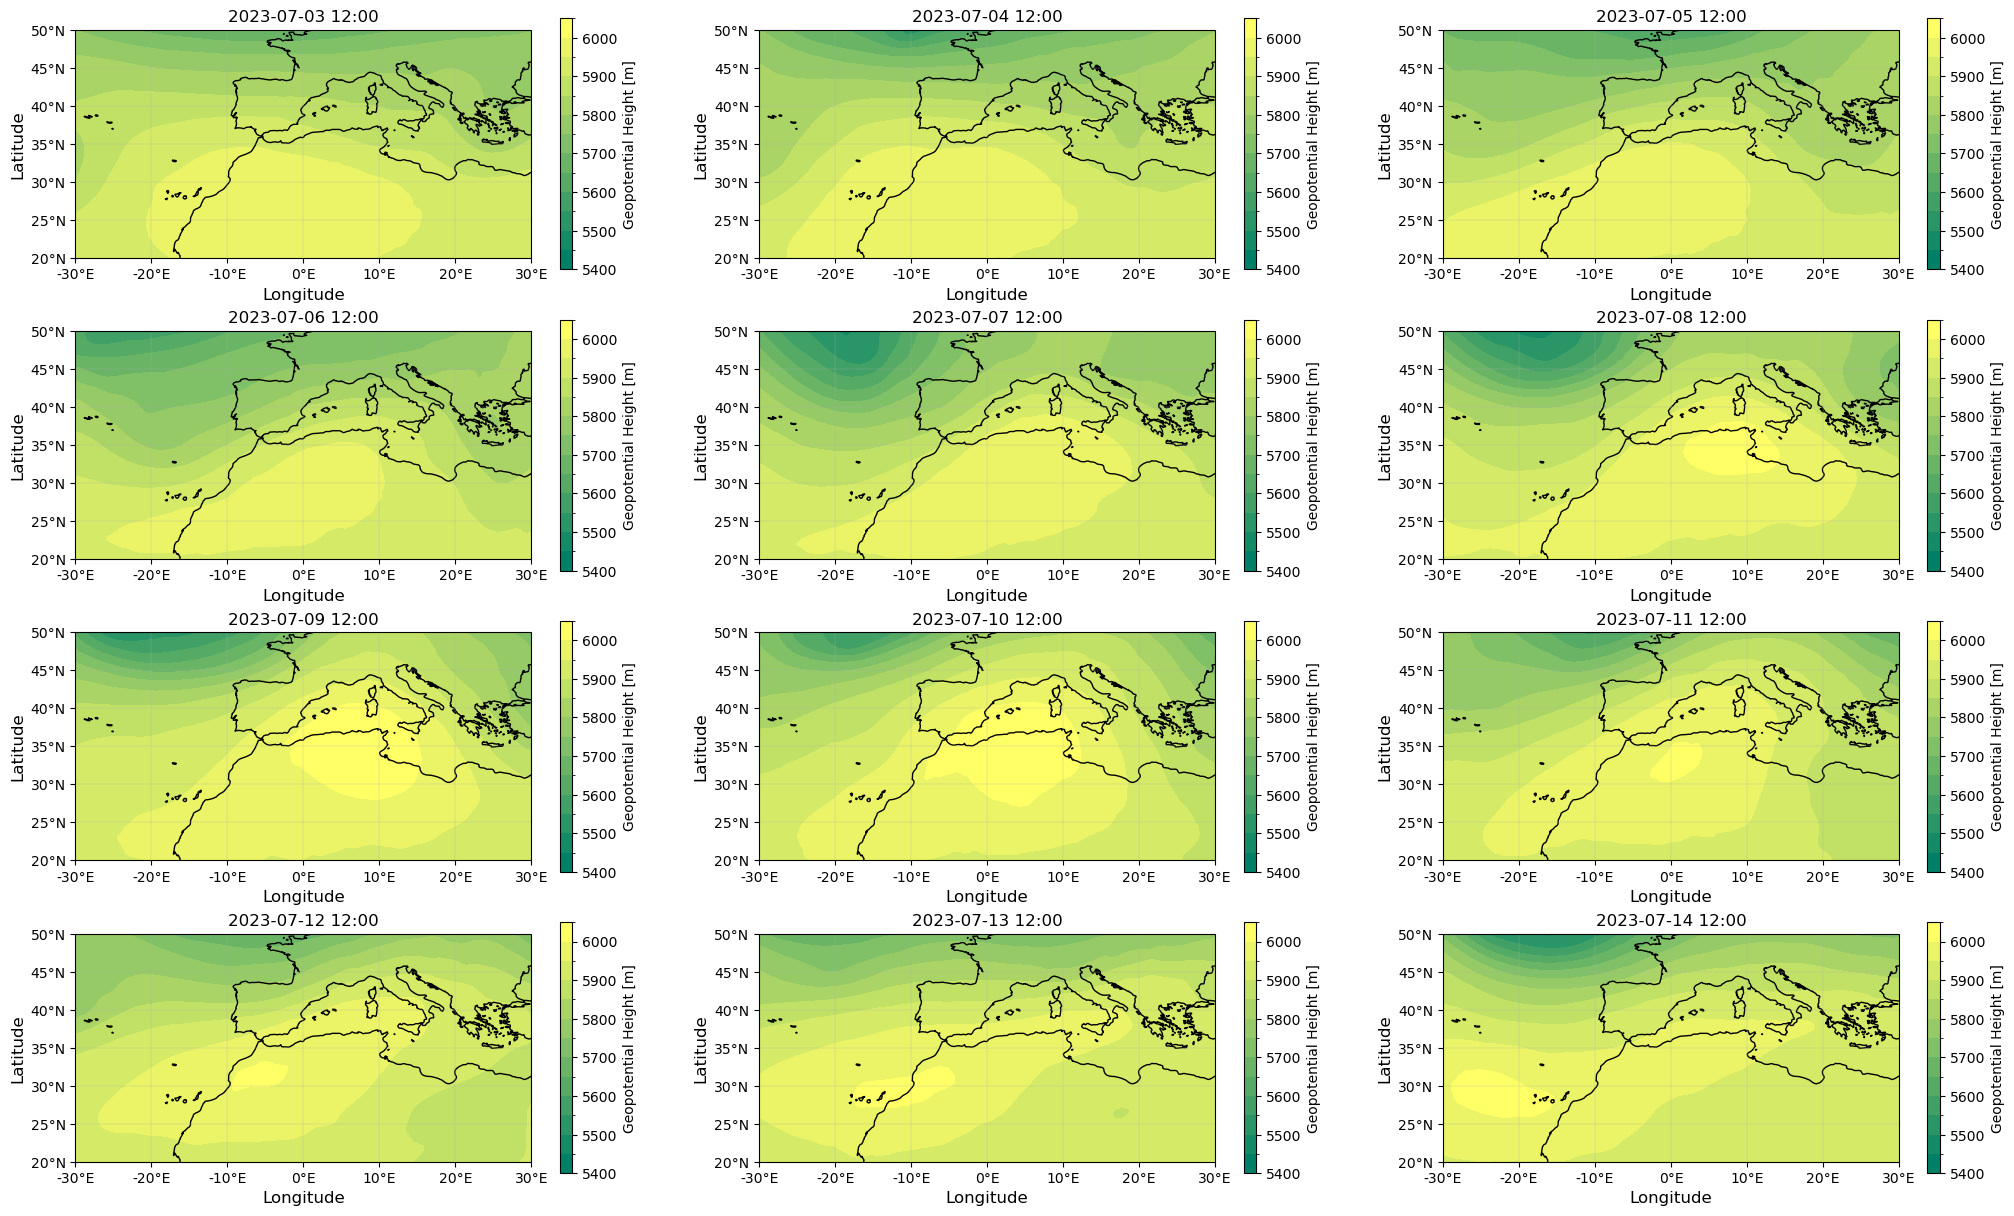

In [231]:
# Overview About the Geopotential Height Using ERA-5 Data
# Define the area of interest, a color bar and the levels
lon_range = slice(-30, 30)
lat_range = slice(20, 50)
levels = np.arange(5400, 6100, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
z_sliced = ERA_data['z'].sel(level = 500, lon=lon_range, lat=lat_range)/9.81

# Select specific timesteps [0 - 68]
z_selected_timesteps = z_sliced['time'].isel(time=slice(10, 68, 4))

# Plot the 2-meter temperature for the selected timesteps
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flat):
    plot_data = z_sliced.sel(time=z_selected_timesteps[i])
    rounded_time = plot_data.time.dt.round('min')  # Round the time values to the nearest minute
    formatted_time = rounded_time.dt.strftime('%Y-%m-%d %H:%M')  # Format the timestamp as 'YYYY-MM-DD HH:MM'
    xplot.contourf(plot_data, ax=ax, cmap='summer', levels=levels, cbar_kwargs={'label': 'Geopotential Height [m]'})
    ax.coastlines()
    ax.gridlines(draw_labels=False, linewidth = 0.2)  # Draw gridlines only for the bottom and left axes
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_yticks(range(20, 51, 5))  # Add explicit ticks for the y-axis
    ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10)  # Add explicit labels for the y-axis
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_xticks(np.arange(-30, 31, 10))  # Add explicit ticks for the x-axis with 10 degree step
    ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  # Add explicit labels for the x-axis
    ax.set_title(formatted_time.values, fontsize=12)  # Set the title with formatted time values

# Save the plot as a PNG file
#plt.savefig('../analysis/ERA_t2m.pdf')

# Show the plot
plt.show()

### Reference for Comparison (Noon [2023.07.12, 12:00 UTC] and Midnight [2023.07.13, 00:00 UTC])

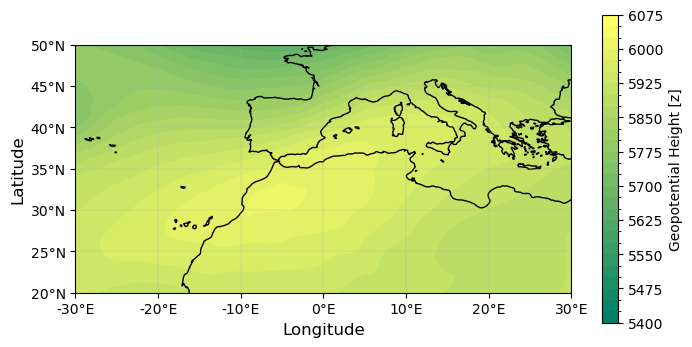

In [232]:
# Reference for Comparison (Noon [2023.07.12, 12:00 UTC] and Midnight [2023.07.13, 00:00 UTC])
# Define the area of interest and the levels of the colorbar
lon_range = slice(-30, 30)
lat_range = slice(20, 50)
levels = np.arange(5400, 6100, 25)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z_500 = ERA_data['z'].sel(level = 500, time='2023-07-12T12:00:00', lon=lon_range, lat=lat_range)/9.81
# remove "#" to use this line --> Reference for the Geopotential Height at Midnight
#ERA_z_500 = ERA_data['z'].sel(level = 500, time='2023-07-13T00:00:00', lon=lon_range, lat=lat_range)/9.81

# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
xplot.contourf(ERA_z_500 , ax=ax, cmap='summer', levels=levels, cbar_kwargs={'label': 'Geopotential Height [z]'})
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

## ERA-5: 2 Meter Air Temperature (Absolute Values)

### Overview About the 2 Meter Air Temperature Using ERA-5 Data

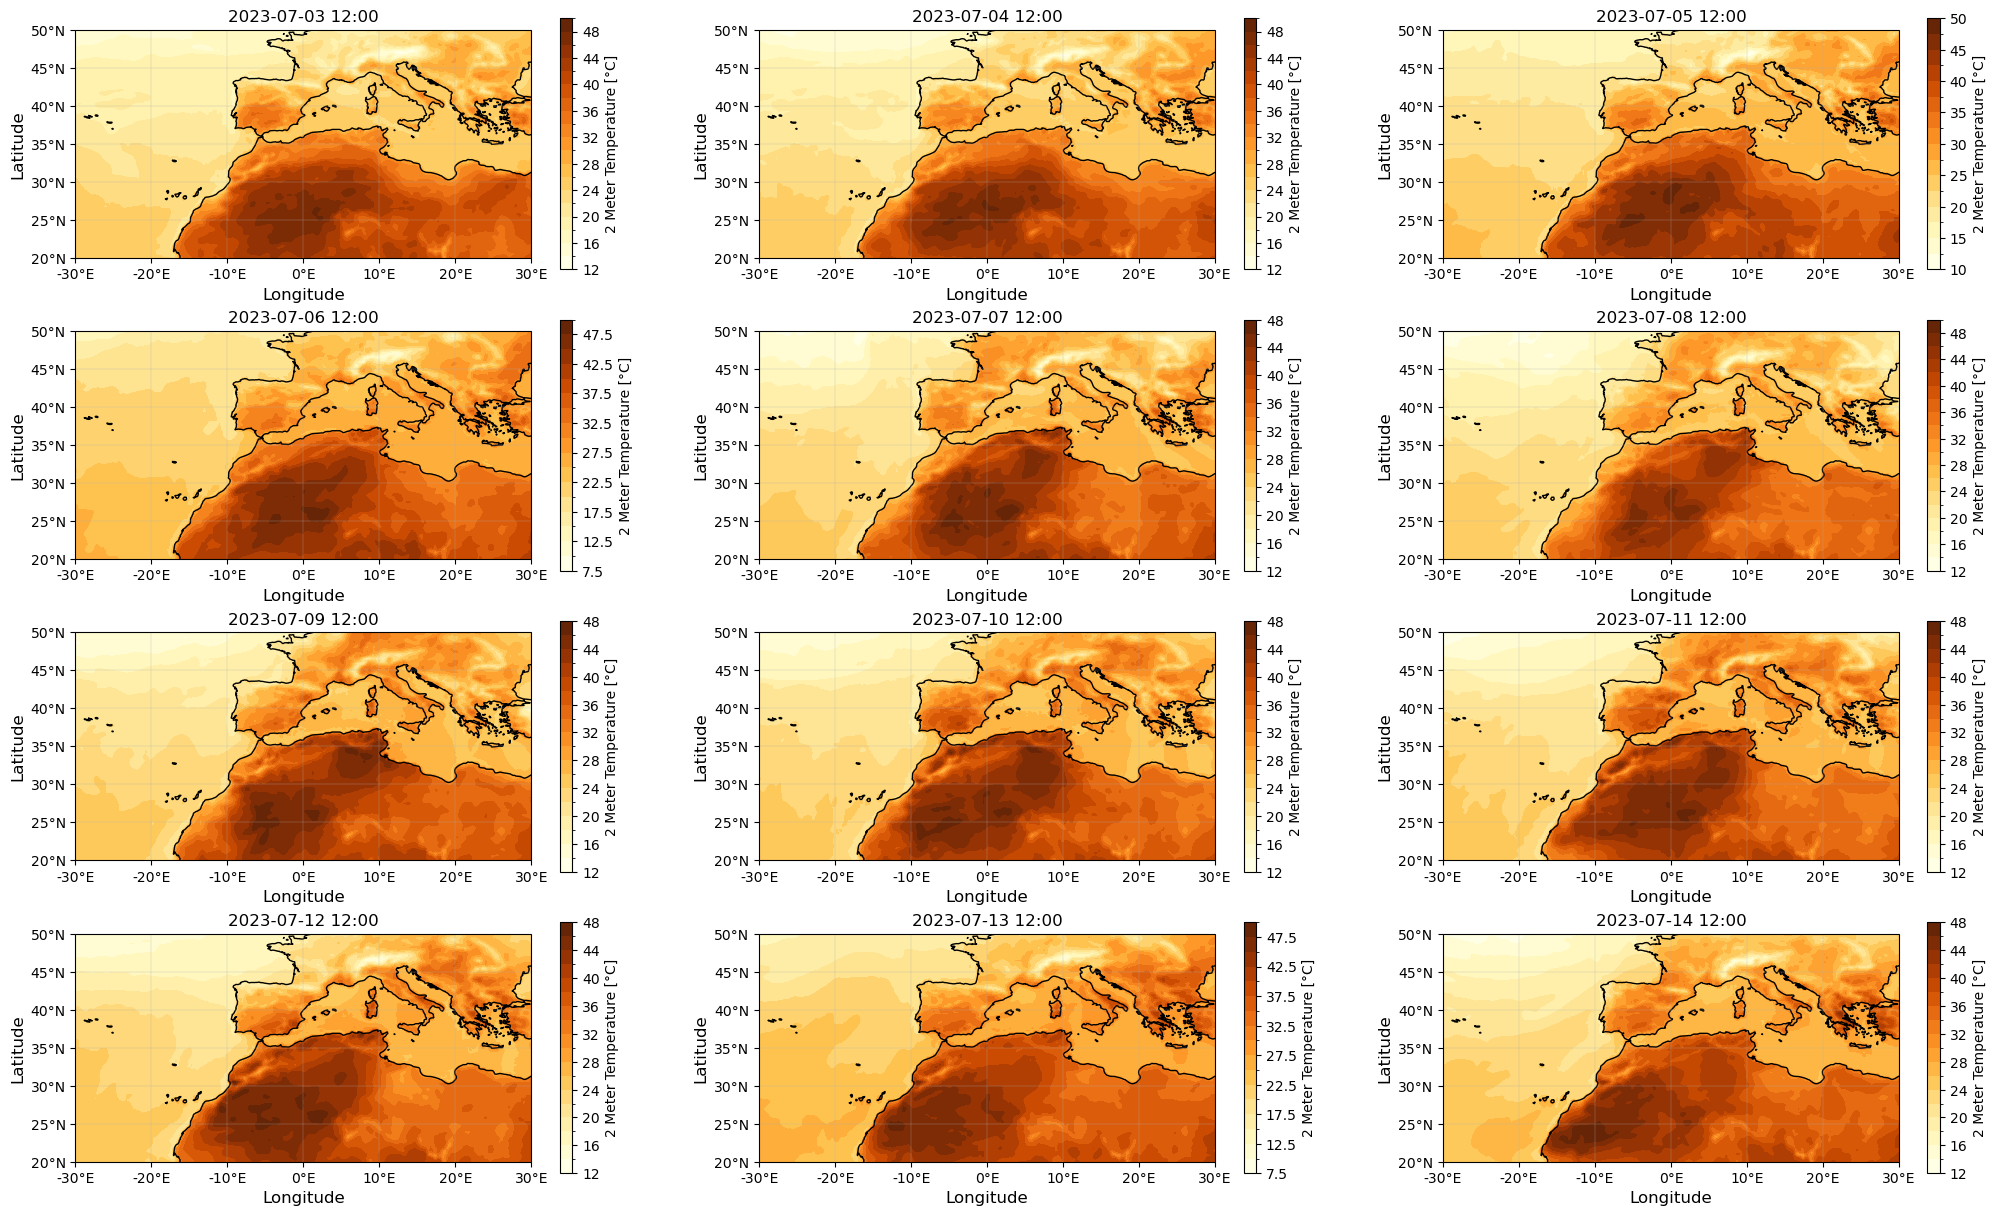

In [233]:
# Overview About the 2 Meter Air Temperature Using ERA-5 Data
# Define the area of interest, a color bar and the levels
lon_range = slice(-30, 30)
lat_range = slice(20, 50)
levels = np.arange(5, 51, 1)
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['white', 'orange', 'red'])

# Select the 2-meter temperature data for the specified longitude and latitude ranges
t2m_sliced = ERA_data['t2m'].sel(lon=lon_range, lat=lat_range)-273.15

# Select specific timesteps
t2m_selected_timesteps = t2m_sliced['time'].isel(time=slice(10, 68, 4))

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flat):
    plot_data = t2m_sliced.sel(time=t2m_selected_timesteps[i])
    rounded_time = plot_data.time.dt.round('min')  # Round the time values to the nearest minute
    formatted_time = rounded_time.dt.strftime('%Y-%m-%d %H:%M')  # Format the timestamp
    xplot.contourf(plot_data, ax=ax, cmap='YlOrBr', levels=20, cbar_kwargs={'label': '2 Meter Temperature [°C]'})
    ax.coastlines()
    ax.gridlines(draw_labels=False, linewidth=0.2)  # Draw gridlines only for the bottom and left axes
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_yticks(range(20, 51, 5))  # Add explicit ticks for the y-axis
    ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10)  # Add explicit labels for the y-axis
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_xticks(np.arange(-30, 31, 10))  # Add explicit ticks for the x-axis with 10 degree step
    ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  # Add explicit labels for the x-axis
    ax.set_title(formatted_time.values, fontsize=12)  # Set the title with formatted time values

# Save the plot as a PNG file
#plt.savefig('../analysis/ERA_t2m.pdf')

# Show the plot
plt.show()

### Reference for Comparison (Noon [2023.07.12, 12:00 UTC] and Midnight [2023.07.13, 00:00 UTC])

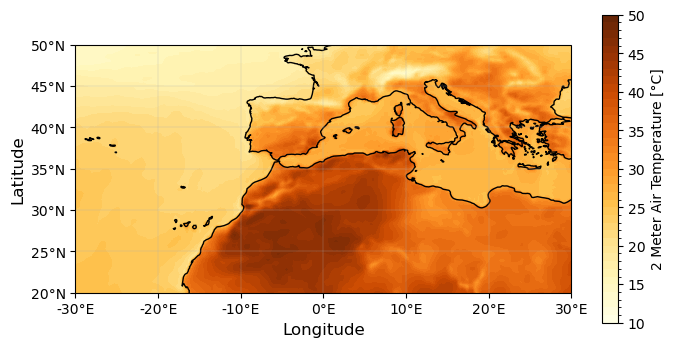

In [234]:
# Reference for Comparison (Noon [2023.07.12, 12:00 UTC] and Midnight [2023.07.13, 00:00 UTC])
# Define the area of interest, the colorbar and the levels of the colorbar
lon_range = slice(-30, 30)
lat_range = slice(20, 50)
levels = np.arange(10, 51, 1)

# Read the 2 meter air temperature at a specific date
# Converte all values into °C because we work with absolut values
ERA_t2m = ERA_data['t2m'].sel(time='2023-07-12T12:00:00', lon=lon_range, lat=lat_range)-273.15
# remove "#" to use this line --> Reference for the 2 meter air temperature at Midnight
#ERA_t2m  = ERA_data['t2m'].sel(time='2023-07-13T00:00:00', lon=lon_range, lat=lat_range)-273.15

# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
xplot.contourf(ERA_t2m, ax=ax, cmap='YlOrBr', levels=levels, cbar_kwargs={'label': '2 Meter Air Temperature [°C]'})
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

# Pangu-Weather Data

## Read the data

In [235]:
# Read the data and edit it to the same format as ERA-5 data

# Function to convert time delta to datetime array
def convert_time_delta_to_datetime(step_values, base_date):
    # Convert nanoseconds into seconds
    seconds = step_values / 1e9
    # Create a new, empty list
    converted_dates = []
    # Create a for loop to iterate over all timesteps
    for second in seconds:
        # Convert the time delta in base date + number of seconds
        converted_dates.append(base_date + np.timedelta64(int(second), 's'))
    # Put it into a numpy array 
    return np.array(converted_dates, dtype='datetime64[ns]')

# Function to read and process Pangu forecast data
def read_and_process_pangu_data(file_path, base_date):
    # Read the Pangu forecast data and sort by latitude
    Pangu_data = xr.open_dataset(file_path).sortby('latitude', ascending=True)
    # Rename the dimension "latitude" and "longitude"
    Pangu_data = Pangu_data.rename({'longitude': 'lon', 'latitude': 'lat'})
    # Change the longitude from a 0°-360° system into a -180°-180° system
    Pangu_data = Pangu_data.assign_coords(lon=((Pangu_data.lon + 180) % 360) - 180)
    # Sort the values along the longitude dimension
    Pangu_data = Pangu_data.sortby('lon', ascending=True)
    # Read the dimension "step"
    delta_ns = Pangu_data['step']
    # Extract the values from the dimension step
    step_values = delta_ns.values
    # Convert time delta to datetime array
    converted_dates_array = convert_time_delta_to_datetime(step_values, base_date)
    # Assign the new dates to the dimension "step"
    Pangu_data = Pangu_data.assign_coords(step=('step', converted_dates_array))
    return Pangu_data

# Read and process Pangu 10-day forecast data
base_date_10_days = np.datetime64('2023-07-02T12:00:00')
Pangu_data_20230702 = read_and_process_pangu_data('../data/HW_EU_20230702.nc', base_date_10_days)

# Read and process Pangu 5-day forecast data
base_date_5_days = np.datetime64('2023-07-07T12:00:00')
Pangu_data_20230707 = read_and_process_pangu_data('../data/HW_EU_20230707.nc', base_date_5_days)

# Read and process Pangu 1-day forecast data
base_date_1_day = np.datetime64('2023-07-11T12:00:00')
Pangu_data_20230711 = read_and_process_pangu_data('../data/HW_EU_20230711.nc', base_date_1_day)

# Make sure that the highest value is 180 and the lowest -180
print(Pangu_data_20230702['lon'].min().values, Pangu_data_20230702['lon'].max().values)
# Print the values
print(Pangu_data_20230702['lon'].values)

-180.0 179.75
[-180.   -179.75 -179.5  ...  179.25  179.5   179.75]


## Pangu: Geopotential Height (Absolute Values)

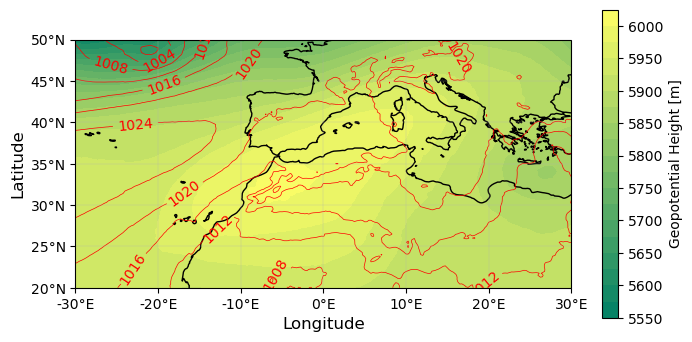

In [236]:
# Define the area of interest and the levels of the color bar
lon_range = slice(-30, 30)
lat_range = slice(20, 50)
levels = np.arange(5550, 6050, 25)

# Read the geopotential height at 500hPa at a specific date
# Convert all values from geopotential into geopotential height, choose a date and an area of interest
Pangu_z = Pangu_data_20230702.z.sel(isobaricInhPa=500, step='2023-07-12T12:00:00', lon=lon_range) / 9.81
# remove "#" to use this line --> Reference for the geopotential height at 500hPa at Midnight
#Pangu_z = Pangu_data_20230702.z.sel(isobaricInhPa=500, step= '2023-07-13T00:00:00', lon = lon_range)/9.81

# Extract surface mean pressure
surface_pressure = Pangu_data_20230702.msl.sel(step='2023-07-12T12:00:00', lon=lon_range) / 100

# Plot the geopotential height at 500hPa for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contourf to plot geopotential height
xplot = ax.contourf(Pangu_z.lon, Pangu_z.lat, Pangu_z, cmap='summer', levels=levels)

# Add a colorbar
cbar = fig.colorbar(xplot, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Geopotential Height [m]')

# Contour mean sea level pressure with red lines and labels
contour = ax.contour(surface_pressure.lon, surface_pressure.lat, surface_pressure, colors='red', linewidths=0.5)
plt.clabel(contour, inline=True, fmt='%1.0f')  # Add labels to the contour lines

# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Show the plot
plt.show()

## Geopotential Height Anomalies at Noon

### 10 Days Forecast Anomaly

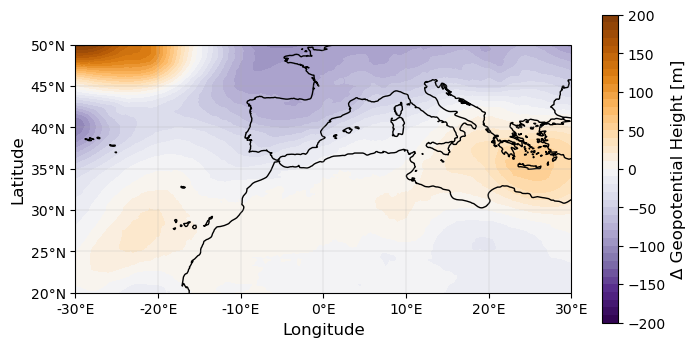

In [237]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-200, 201, 10)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['z'].sel(level=500, time='2023-07-12T12:00:00') / 9.81

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230702.z.sel(isobaricInhPa=500, step='2023-07-12T12:00:00') / 9.81

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap=cm.PuOr.reversed(), levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 Geopotential Height [m]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 5 Days Forecast Anomaly

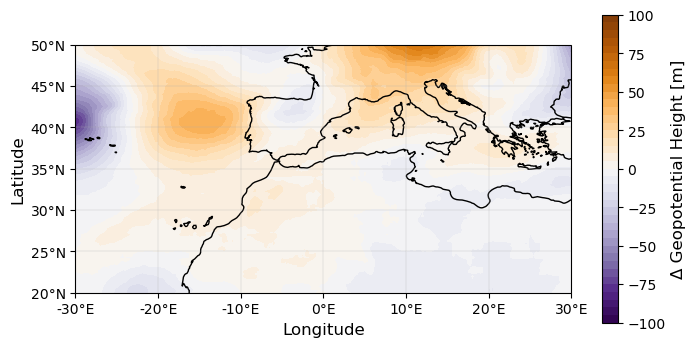

In [238]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-100, 101, 5)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['z'].sel(level=500, time='2023-07-12T12:00:00') / 9.81

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230707.z.sel(isobaricInhPa=500, step='2023-07-12T12:00:00') / 9.81

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap=cm.PuOr.reversed(), levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 Geopotential Height [m]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 1 Day Forecast Anomaly

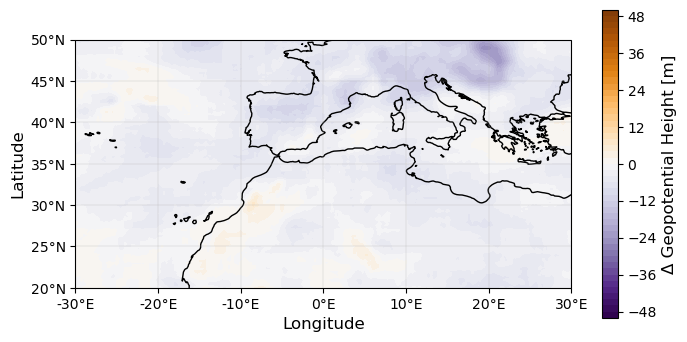

In [239]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-50, 51, 2)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['z'].sel(level=500, time='2023-07-12T12:00:00') / 9.81

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230711.z.sel(isobaricInhPa=500, step='2023-07-12T12:00:00') / 9.81

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap=cm.PuOr.reversed(), levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 Geopotential Height [m]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

## Geopotential Height Anomalies at Midnight

### 10 Days Forecast Anomaly

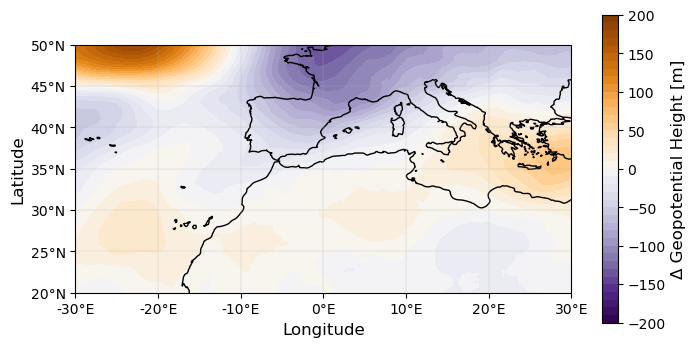

In [240]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-200, 201, 10)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['z'].sel(level=500, time='2023-07-13T00:00:00') / 9.81

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230702.z.sel(isobaricInhPa=500, step='2023-07-13T00:00:00') / 9.81

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap=cm.PuOr.reversed(), levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 Geopotential Height [m]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 5 Days Forecast Anomaly

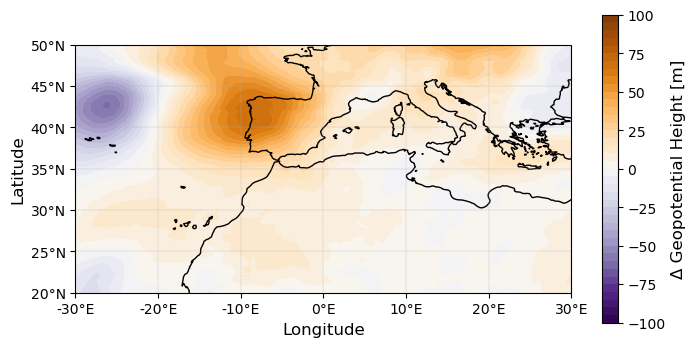

In [241]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-100, 101, 5)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['z'].sel(level=500, time='2023-07-13T00:00:00') / 9.81

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230707.z.sel(isobaricInhPa=500, step='2023-07-13T00:00:00') / 9.81

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap=cm.PuOr.reversed(), levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 Geopotential Height [m]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 1 Day Forecast Anomaly

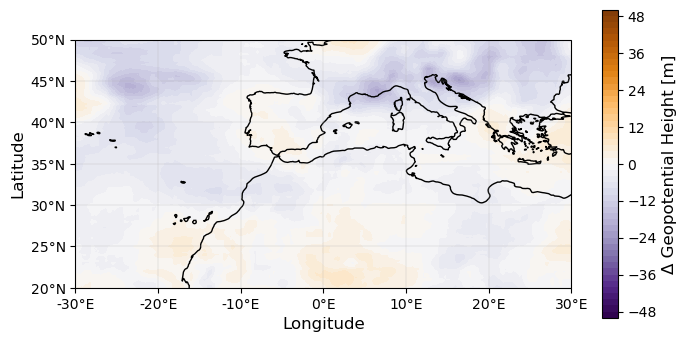

In [242]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-50, 51, 2)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['z'].sel(level=500, time='2023-07-13T00:00:00') / 9.81

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230711.z.sel(isobaricInhPa=500, step='2023-07-13T00:00:00') / 9.81

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap=cm.PuOr.reversed(), levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 Geopotential Height [m]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

## Pangu: 2 Meter Air Temperature (Absolute Values)

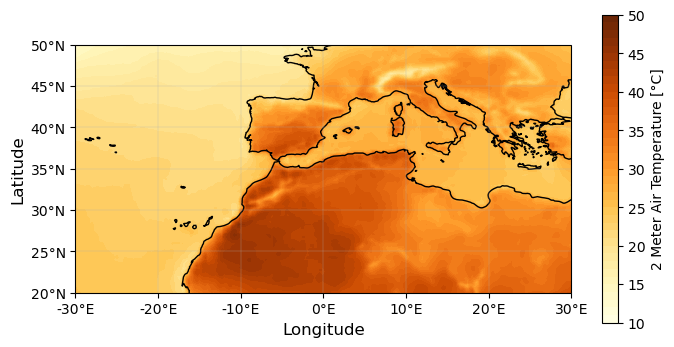

In [243]:
# Define the area of interest and the levels of the color bar
lon_range = slice(-30, 30)
lat_range = slice(20, 50)
levels = np.arange(10, 51, 1)

# Read the geopotential height at 500hPa at a specific date
# Convert all values from geopotential into geopotential height, choose a date and an area of interest
Pangu_z = Pangu_data_20230702.t2.sel(step='2023-07-12T12:00:00', lon=lon_range)-273.15
# remove "#" to use this line --> Reference for the geopotential height at 500hPa at Midnight
#Pangu_z = Pangu_data_20230702.z.sel(isobaricInhPa=500, step= '2023-07-13T00:00:00', lon = lon_range)/9.81

# Plot the geopotential height at 500hPa for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contourf to plot geopotential height
xplot = ax.contourf(Pangu_z.lon, Pangu_z.lat, Pangu_z, cmap='YlOrBr', levels=levels)

# Add a colorbar
cbar = fig.colorbar(xplot, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('2 Meter Air Temperature [°C]')

# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Show the plot
plt.show()

## 2 Meter Air Temperature Anomalies at Noon

### 10 Day Forecast

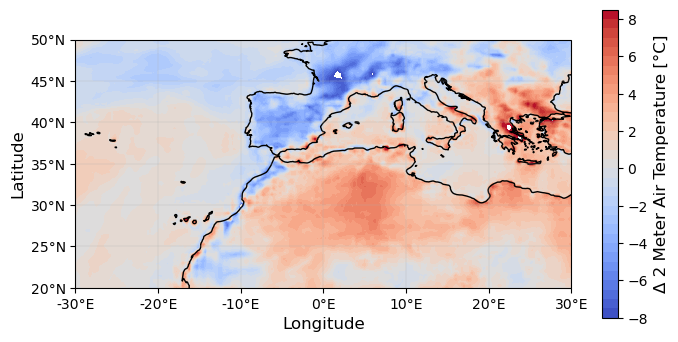

In [244]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-8, 9, 0.5)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['t2m'].sel(time='2023-07-12T12:00:00')-273.15

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230702.t2.sel(step='2023-07-12T12:00:00')-273.15

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap='coolwarm', levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 2 Meter Air Temperature [°C]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 5 Days Forescast Anomaly

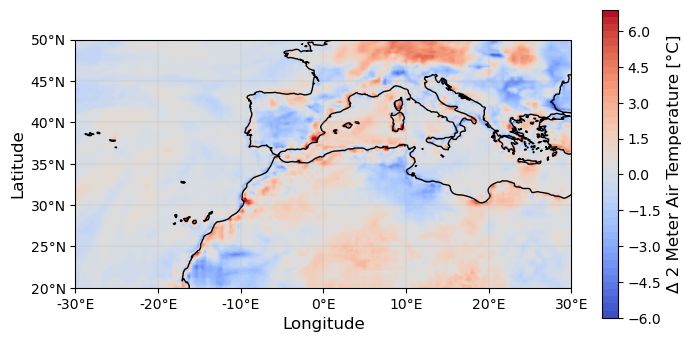

In [245]:
# 5 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-6, 7, 0.3)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['t2m'].sel(time='2023-07-12T12:00:00')-273.15

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230707.t2.sel(step='2023-07-12T12:00:00')-273.15

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap='coolwarm', levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 2 Meter Air Temperature [°C]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 1 Day Forecast Anomaly

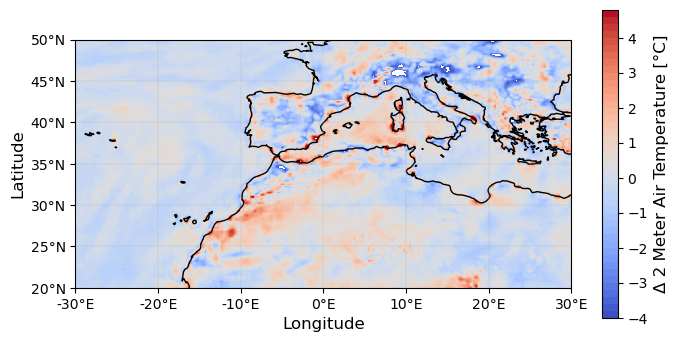

In [246]:
# 1 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-4, 5, 0.2)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['t2m'].sel(time='2023-07-12T12:00:00')-273.15

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230711.t2.sel(step='2023-07-12T12:00:00')-273.15

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap='coolwarm', levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 2 Meter Air Temperature [°C]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

## 2 Meter Air Temperature Anomalies at Midnight

### 10 Days Forecast Anomaly

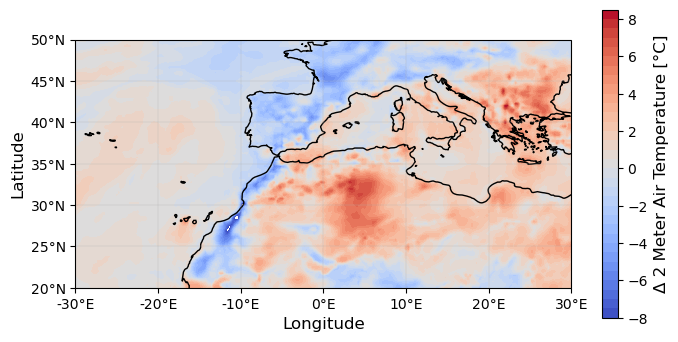

In [247]:
# 10 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-8, 9, 0.5)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['t2m'].sel(time='2023-07-13T00:00:00')-273.15

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230702.t2.sel(step='2023-07-13T00:00:00')-273.15

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap='coolwarm', levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 2 Meter Air Temperature [°C]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 5 Days Forecast Anomaly

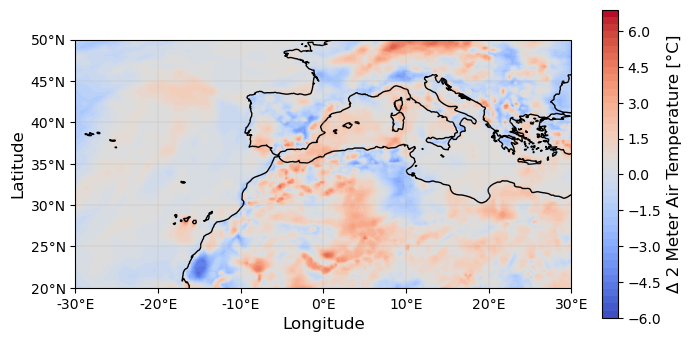

In [248]:
# 5 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-6, 7, 0.3)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['t2m'].sel(time='2023-07-13T00:00:00')-273.15

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230707.t2.sel(step='2023-07-13T00:00:00')-273.15

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap='coolwarm', levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 2 Meter Air Temperature [°C]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

### 1 Day Forecast Anomaly

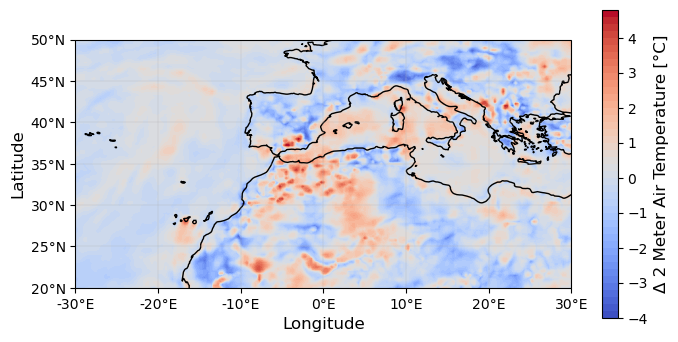

In [249]:
# 1 Days Forecast Anomaly (noon)
# Define the area and the levels for the colorbar
levels = np.arange(-4, 5, 0.2)
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Read the geopotential height at 500hPa at a specific date
# we divide all values by the gravitational acceleration because the values refer to the geopotential 
ERA_z = ERA_data['t2m'].sel(time='2023-07-13T00:00:00')-273.15

# Read the forecast for the geopotential height at 500hPa at a specific date using Pangu data
Pangu_z = Pangu_data_20230711.t2.sel(step='2023-07-13T00:00:00')-273.15

# Calculate Anomaly
z_anomaly = ERA_z - Pangu_z
# Define the area of interest
z_anomaly = z_anomaly.sel(lon=lon_range, lat=lat_range)

# Plot the 2-meter temperature for the selected timesteps
# Plot the 2-meter temperature for the selected timesteps
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# Use contour and define some parameters
contour_plot = ax.contourf(z_anomaly.lon, z_anomaly.lat, z_anomaly, cmap='coolwarm', levels=levels)
# Add coastlines
ax.coastlines()
# Draw gridlines but no labels (we will do that later using a for loop) 
ax.gridlines(draw_labels=False, linewidth = 0.2)  

# Add labels and ticks
ax.set_ylabel('Latitude', fontsize=12)
# Define the latitudes
ax.set_yticks(range(20, 51, 5))  
# Set the latitudes using a for-loop
ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10) 
ax.set_xlabel('Longitude', fontsize=12)
# Define the longitude
ax.set_xticks(np.arange(-30, 31, 10)) 
# Set the longitudes using a for-loop
ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  
# we do not want any title because we will be using captions in the report
ax.set_title(None)

# Add colorbar
cbar = plt.colorbar(contour_plot, ax=ax, orientation='vertical')
cbar.set_label('\u0394 2 Meter Air Temperature [°C]', fontsize=12)

# Save the plot as a PDF file
#plt.savefig('../analysis/ERA_geopot_selected_timesteps_07.12.noon.pdf')

# Show the plot
plt.show()

# Further Analyisis

## Scatter- and Lineplots

### Southern Europe

In [250]:
# Function to investigate the absolute values of the 2 meter temperature at a specific area
def plot_area_temperature_absolute(lat_1, lat_2, lon_1, lon_2, area_name):
    # Define an area of Southern Europe [-10°E - 25°E; 35°N - 45°N]
    latitude = slice(lat_1,lat_2)
    longitude = slice(lon_1, lon_2)

    t2m_area = ERA_data['t2m'].sel(lon=longitude, lat=latitude) - 273.15 
    mean_temperature_time = t2m_area.mean(dim=('lon', 'lat'))
    time_index = t2m_area.time.to_pandas()
    temperature_values = mean_temperature_time.values

    # Select the 2-meter temperature data (Pangu) for the nearest coordinates of Rome
    t2_area_02 = Pangu_data_20230702['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P2 = t2_area_02.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_02 = mean_temperature_time_P2.values
    time_index_Pangu_02 = t2_area_02.step.to_pandas()

    t2_area_07 = Pangu_data_20230707['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P7 = t2_area_07.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_07 = mean_temperature_time_P7.values
    time_index_Pangu_07 = t2_area_07.step.to_pandas()

    t2_area_11 = Pangu_data_20230711['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P11 = t2_area_11.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_11 = mean_temperature_time_P11.values
    time_index_Pangu_11 = t2_area_11.step.to_pandas()

    # Plot line plot with temperature values over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_index, temperature_values, marker='o', linestyle='-', markersize=3, linewidth=0.3, color='black', label='ERA-5 Values')
    plt.plot(time_index_Pangu_02, temperature_values_Pangu_02, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='red', label='Pangu 10 Days Forecast')
    plt.plot(time_index_Pangu_07, temperature_values_Pangu_07, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='orange', label='Pangu 5 Days Forecast')
    plt.plot(time_index_Pangu_11, temperature_values_Pangu_11, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='magenta', label='Pangu 1 Day Forecast')
    plt.xlabel('Date [Year-Month-Day Hours:Minutes]')
    plt.ylabel('2 Meter Temperature [°C]')
    plt.xticks(rotation=45) 
    plt.grid(True)
    # Change labels in x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.axvline(pd.Timestamp('2023-07-11T12:00:00'), color='magenta', linestyle='--', label='Startingg Date: 1 Day Forecast', linewidth = 0.5)
    #plt.text(pd.Timestamp('2023-07-11T12:00:00'), 24, '1 Day Forecast', rotation=90, va='bottom', ha='right')
    plt.axvline(pd.Timestamp('2023-07-07T12:00:00'), color='orange', linestyle='--', label='Startingg Date: 5 Day Forecast', linewidth = 0.5)
    #plt.text(pd.Timestamp('2023-07-07T12:00:00'), 24, '5 Day Forecast', rotation=90, va='bottom', ha='right')
    plt.axvline(pd.Timestamp('2023-07-02T12:00:00'), color='red', linestyle='--', label='Startingg Date: 10 Day Forecast', linewidth = 0.5)
    #plt.text(pd.Timestamp('2023-07-02T12:00:00'), 24, '10 Day Forecast', rotation=90, va='bottom', ha='right')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title(f'Temperature (absolute values) for {area_name}')
    plt.show()
    return

In [251]:
# Function to investigate the absolute values of the 2 meter temperature (zoomed in) at a specific area
def plot_area_zoom_temperature_absolute(lat_1, lat_2, lon_1, lon_2, area_name):
    # Define an area of Southern Europe [-10°E - 25°E; 35°N - 45°N]
    latitude = slice(lat_1,lat_2)
    longitude = slice(lon_1, lon_2)

    t2m_area = ERA_data['t2m'].sel(lon=longitude, lat=latitude) - 273.15 
    mean_temperature_time = t2m_area.mean(dim=('lon', 'lat'))
    time_index = t2m_area.time.to_pandas()
    temperature_values = mean_temperature_time.values

    # Select the 2-meter temperature data (Pangu) for the nearest coordinates of Rome
    t2_area_02 = Pangu_data_20230702['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P2 = t2_area_02.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_02 = mean_temperature_time_P2.values
    time_index_Pangu_02 = t2_area_02.step.to_pandas()

    t2_area_07 = Pangu_data_20230707['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P7 = t2_area_07.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_07 = mean_temperature_time_P7.values
    time_index_Pangu_07 = t2_area_07.step.to_pandas()

    t2_area_11 = Pangu_data_20230711['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P11 = t2_area_11.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_11 = mean_temperature_time_P11.values
    time_index_Pangu_11 = t2_area_11.step.to_pandas()

    # Filter the temperature values for a specific time range
    start_time = pd.Timestamp('2023-07-11T18:00:00')
    end_time = pd.Timestamp('2023-07-15T12:00:00')
    time_mask = (time_index >= start_time) & (time_index <= end_time)
    filtered_temperature_values = temperature_values[time_mask]
    filtered_time_index = time_index[time_mask]

    # Plot line plot with temperature values over time
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_time_index, filtered_temperature_values, marker='o', linestyle='-', markersize=3, linewidth=0.3, color='black', label='ERA-5 Values')
    plt.plot(time_index_Pangu_02, temperature_values_Pangu_02, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='red', label='Pangu 10 Days Forecast')
    plt.plot(time_index_Pangu_07, temperature_values_Pangu_07, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='orange', label='Pangu 5 Days Forecast')
    plt.plot(time_index_Pangu_11, temperature_values_Pangu_11, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='magenta', label='Pangu 1 Day Forecast')
    plt.xlabel('Date [Year-Month-Day Hours:Minutes]')
    plt.ylabel('2 Meter Temperature [°C]')
    plt.xticks(rotation=45) 
    plt.grid(True)
    # Change labels in x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title(f'Temperature (absolute values) for {area_name}')
    plt.show()
    return

In [252]:
# Function to investigate the 2 meter temperature anomaly at a specific area
def plot_area_temperature_anomly(lat_1, lat_2, lon_1, lon_2, area_name):
    # Define an area of Southern Europe [-10°E - 25°E; 35°N - 45°N]
    latitude = slice(lat_1,lat_2)
    longitude = slice(lon_1, lon_2)

    t2m_area = ERA_data['t2m'].sel(lon=longitude, lat=latitude) - 273.15 
    mean_temperature_time = t2m_area.mean(dim=('lon', 'lat'))
    time_index = t2m_area.time.to_pandas()
    temperature_values = mean_temperature_time.values

    # Select the 2-meter temperature data (Pangu) for the nearest coordinates of Rome
    t2_area_02 = Pangu_data_20230702['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P2 = t2_area_02.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_02 = mean_temperature_time_P2.values
    time_index_Pangu_02 = t2_area_02.step.to_pandas()

    t2_area_07 = Pangu_data_20230707['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P7 = t2_area_07.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_07 = mean_temperature_time_P7.values
    time_index_Pangu_07 = t2_area_07.step.to_pandas()

    t2_area_11 = Pangu_data_20230711['t2'].sel(lon=longitude, lat=latitude) - 273.15
    mean_temperature_time_P11 = t2_area_11.mean(dim=('lon', 'lat'))
    temperature_values_Pangu_11 = mean_temperature_time_P11.values
    time_index_Pangu_11 = t2_area_11.step.to_pandas()

    # Filter the temperature values for a specific time range
    start_time = pd.Timestamp('2023-07-12T12:00:00')
    end_time = pd.Timestamp('2023-07-15T00:00:00')
    time_mask = (time_index >= start_time) & (time_index <= end_time)
    # Filter the temperature values for a specific time range
    time_mask_P2 = (time_index_Pangu_02 >= start_time) & (time_index_Pangu_02 <= end_time)
    filtered_time_index_P2 = time_index_Pangu_02[time_mask_P2]
    time_mask_P7 = (time_index_Pangu_07 >= start_time) & (time_index_Pangu_07 <= end_time)
    filtered_time_index_P7 = time_index_Pangu_07[time_mask_P7]
    time_mask_P11 = (time_index_Pangu_11 >= start_time) & (time_index_Pangu_11 <= end_time)
    filtered_time_index_P11 = time_index_Pangu_11[time_mask_P11]
    
    Pangu_02 = temperature_values[time_mask] - temperature_values_Pangu_02[time_mask_P2]
    Pangu_07 = temperature_values[time_mask] - temperature_values_Pangu_07[time_mask_P7]
    Pangu_11 = temperature_values[time_mask] - temperature_values_Pangu_11[time_mask_P11]

    # Plot line plot with temperature values over time
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_time_index_P2, Pangu_02, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='red', label='Pangu 10 Days Forecast')
    plt.plot(filtered_time_index_P7, Pangu_07, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='orange', label='Pangu 5 Days Forecast')
    plt.plot(filtered_time_index_P11, Pangu_11, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='magenta', label='Pangu 1 Day Forecast')
    plt.xlabel('Date [Year-Month-Day Hours:Minutes]')
    plt.ylabel('2 Meter Temperature [°C]')
    plt.xticks(rotation=45) 
    plt.grid(True)
    # Change labels in x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.axhline(0, color='black', linestyle='-', label='ERA-5 Baseline', linewidth = 1)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title(f'Temperature (absolute values) for {area_name}')

        # Create DataFrame
    dates = time_mask_P2[time_mask_P2].index
    dates_list = dates.tolist()

    df = pd.DataFrame()
    data = {
        'Time': dates_list,
        'Location': np.repeat(area_name, len(dates_list)),
        'Pangu 10 Day [°C]': Pangu_02,
        'Pangu 5 Day [°C]': Pangu_07,
        'Pangu 1 Day [°C]': Pangu_11,
        'ERA-5 [°C]': temperature_values[time_mask]
    }
    df = df.assign(**data)
    file_path = os.path.join('../data/Areas', f'{area_name}.csv')
    df.to_csv(file_path)

    df_1 = df.describe()
    file_path_stat = os.path.join('../data/Areas', f'{area_name}_stat.csv')
    df_1.to_csv(file_path_stat)
    # Storing plot and DataFrame in a list and returning
    result = [plt, df, df_1]
    return result

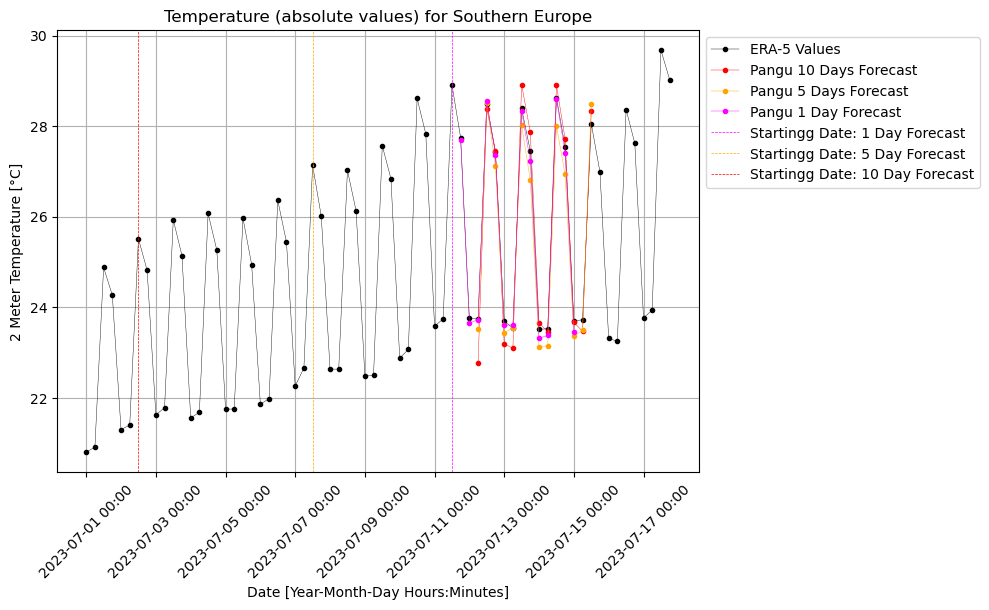

In [253]:
# Function call plot_area_temperature_absolute(lat_1, Lat_2, lon_1, lon_2, "area_name")
plot_area_temperature_absolute(35, 45, -10, 25, "Southern Europe")

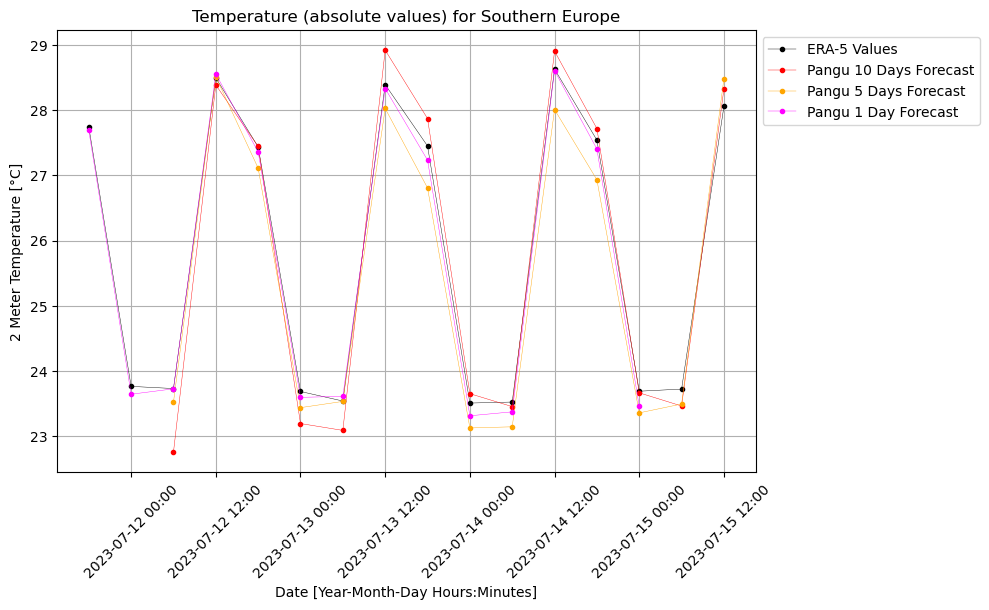

In [254]:
# Function call plot_area_zoom_temperature_absolute(lat_1, Lat_2, lon_1, lon_2, "area_name")
plot_area_zoom_temperature_absolute(35, 45, -10, 25, "Southern Europe")

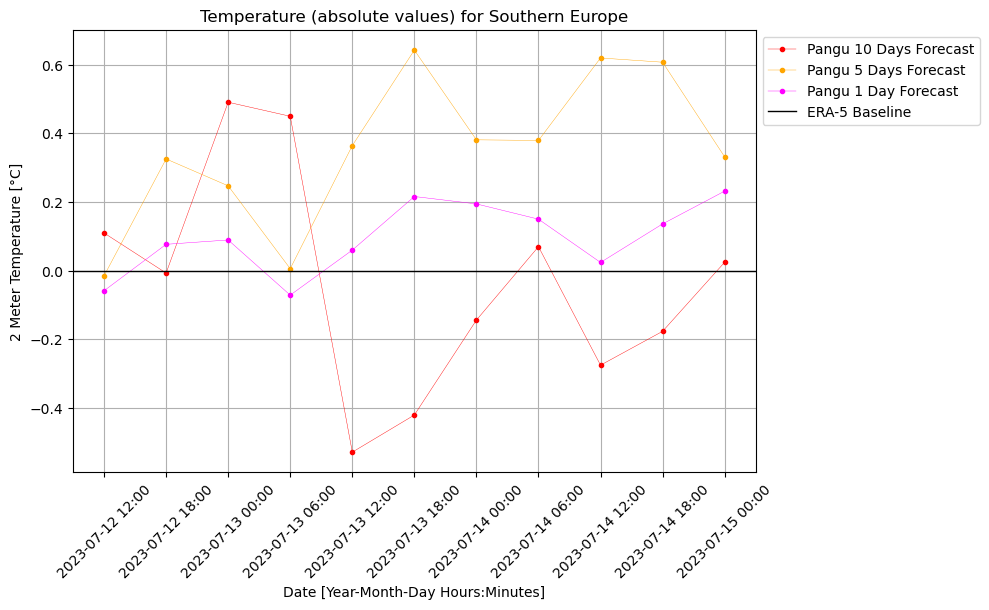

In [255]:
# Function call plot_area_temperature_anomly(lat_1, Lat_2, lon_1, lon_2, "area_name")
results = plot_area_temperature_anomly(35, 45, -10, 25, "Southern Europe")

In [256]:
print(results[2])

                      Time  Pangu 10 Day [°C]  Pangu 5 Day [°C]  \
count                   11          11.000000         11.000000   
mean   2023-07-13 18:00:00          -0.036954          0.353854   
min    2023-07-12 12:00:00          -0.528856         -0.014925   
25%    2023-07-13 03:00:00          -0.226014          0.286544   
50%    2023-07-13 18:00:00          -0.006844          0.364624   
75%    2023-07-14 09:00:00           0.089989          0.494588   
max    2023-07-15 00:00:00           0.491076          0.642973   
std                    NaN           0.321047          0.221386   

       Pangu 1 Day [°C]  ERA-5 [°C]  
count         11.000000   11.000000  
mean           0.095503   25.989693  
min           -0.071177   23.509586  
25%            0.042064   23.613846  
50%            0.089567   27.434841  
75%            0.172461   27.964161  
max            0.231941   28.626995  
std            0.102918    2.332562  


### Cities

In [257]:
# Function to investigate the absolute values of the 2 meter temperature at a specific location
def plot_temperature_absolute(lat, lon, location_name):
    # Overview about Rome
    # Define an area of Southern Europe [-10°E - 25°E; 35°N - 45°N]
    latitude = 41.902782
    longitude = 12.496366

    t2m_city = ERA_data['t2m'].sel(lon=longitude, lat=latitude, method='nearest') - 273.15 
    time_index = t2m_city.time.to_pandas()
    temperature_values = t2m_city.values

    # Select the 2-meter temperature data (Pangu) for the nearest coordinates of Rome
    t2_city_02 = Pangu_data_20230702['t2'].sel(lon=longitude, lat=latitude, method='nearest') - 273.15
    time_index_Pangu_02 = t2_city_02.step.to_pandas()
    temperature_values_Pangu_02 = t2_city_02.values

    t2_city_07 = Pangu_data_20230707['t2'].sel(lon=longitude, lat=latitude, method='nearest') - 273.15
    time_index_Pangu_07 = t2_city_07.step.to_pandas()
    temperature_values_Pangu_07 = t2_city_07.values

    t2_city_11 = Pangu_data_20230711['t2'].sel(lon=longitude, lat=latitude, method='nearest') - 273.15
    time_index_Pangu_11 = t2_city_11.step.to_pandas()
    temperature_values_Pangu_11 = t2_city_11.values

    # Plot line plot with temperature values over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_index, temperature_values, marker='o', linestyle='-', markersize=3, linewidth=0.3, color='black', label='ERA-5 Values')
    plt.plot(time_index_Pangu_02, temperature_values_Pangu_02, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='red', label='Pangu 10 Days Forecast')
    plt.plot(time_index_Pangu_07, temperature_values_Pangu_07, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='orange', label='Pangu 5 Days Forecast')
    plt.plot(time_index_Pangu_11, temperature_values_Pangu_11, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='magenta', label='Pangu 1 Day Forecast')
    plt.xlabel('Date [Year-Month-Day Hours:Minutes]')
    plt.ylabel('2 Meter Temperature [°C]')
    plt.xticks(rotation=45) 
    plt.grid(True)
    # Change labels in x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.axvline(pd.Timestamp('2023-07-11T12:00:00'), color='magenta', linestyle='--', label='Starting Date: 1 Day Forecast', linewidth = 0.5)
    #plt.text(pd.Timestamp('2023-07-11T12:00:00'), 24, '1 Day Forecast', rotation=90, va='bottom', ha='right')
    plt.axvline(pd.Timestamp('2023-07-07T12:00:00'), color='orange', linestyle='--', label='Starting Date: 5 Day Forecast', linewidth = 0.5)
    #plt.text(pd.Timestamp('2023-07-07T12:00:00'), 24, '5 Day Forecast', rotation=90, va='bottom', ha='right')
    plt.axvline(pd.Timestamp('2023-07-02T12:00:00'), color='red', linestyle='--', label='Starting Date: 10 Day Forecast', linewidth = 0.5)
    #plt.text(pd.Timestamp('2023-07-02T12:00:00'), 24, '10 Day Forecast', rotation=90, va='bottom', ha='right')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title(f'Temperature (absolute values) for {location_name}')
    plt.show()
    return

In [258]:
# Function to investigate the absolute values of the 2 meter temperature (zoomed in) at a specific location
def plot_zoomed_temperature_absolute(lat, lon, location_name):
    # Zoom in for Rome
    # Coordinates Rome
    latitude = lat
    longitude = lon

    # Select the 2-meter temperature data (ERA-5) for the nearest coordinates of Rome
    t2m_city = ERA_data['t2m'].sel(lon=longitude, lat=latitude, method='nearest') - 273.15 
    time_index = t2m_city.time.to_pandas()
    temperature_values = t2m_city.values

    # Select the 2-meter temperature data (Pangu) for the nearest coordinates of Rome
    t2_city_02 = Pangu_data_20230702['t2'].sel(lon=longitude, lat=latitude,method='nearest') - 273.15
    time_index_Pangu_02 = t2_city_02.step.to_pandas()
    temperature_values_Pangu_02 = t2_city_02.values

    t2_city_07 = Pangu_data_20230707['t2'].sel(lon=longitude, lat=latitude, method='nearest') - 273.15
    time_index_Pangu_07 = t2_city_07.step.to_pandas()
    temperature_values_Pangu_07 = t2_city_07.values

    t2_city_11 = Pangu_data_20230711['t2'].sel(lon=longitude, lat=latitude, method='nearest') - 273.15
    time_index_Pangu_11 = t2_city_11.step.to_pandas()
    temperature_values_Pangu_11 = t2_city_11.values

    # Filter the temperature values for a specific time range
    start_time = pd.Timestamp('2023-07-11T18:00:00')
    end_time = pd.Timestamp('2023-07-15T12:00:00')
    time_mask = (time_index >= start_time) & (time_index <= end_time)
    filtered_temperature_values = temperature_values[time_mask]

    # Plot line plot with temperature values over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_index[time_mask], filtered_temperature_values, marker='o', linestyle='-', markersize=3, linewidth=0.6, color='black', label='ERA-5 Values')
    plt.plot(time_index_Pangu_02, temperature_values_Pangu_02, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='red', label='Pangu 10 Days Forecast')
    plt.plot(time_index_Pangu_07, temperature_values_Pangu_07, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='orange', label='Pangu 5 Days Forecast')
    plt.plot(time_index_Pangu_11, temperature_values_Pangu_11, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='magenta', label='Pangu 1 Day Forecast')
    plt.xlabel('Date [Year-Month-Day Hours:Minutes]')
    plt.ylabel('2 Meter Temperature [°C]')
    plt.xticks(rotation=45) 
    plt.grid(True)
    # Change labels in x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title(f'Temperature (absolute values) for {location_name}')
    plt.show()
    
    return 

In [259]:
# Function to investigate an anomaly of the 2 meter temperature at a specific location

def plot_temperature_anomalies(lat, lon, location_name):
    # Select the 2-meter temperature data (ERA-5) for the nearest coordinates of the specified location
    t2m_city = ERA_data['t2m'].sel(lon=lon, lat=lat, method='nearest') - 273.15 
    time_index = t2m_city.time.to_pandas()
    temperature_values = t2m_city.values

    # Select the 2-meter temperature data (Pangu) for the nearest coordinates of the specified location
    t2_city_02 = Pangu_data_20230702['t2'].sel(lon=lon, lat=lat,method='nearest') - 273.15
    time_index_Pangu_02 = t2_city_02.step.to_pandas()
    temperature_values_Pangu_02 = t2_city_02.values

    t2_city_07 = Pangu_data_20230707['t2'].sel(lon=lon, lat=lat, method='nearest') - 273.15
    time_index_Pangu_07 = t2_city_07.step.to_pandas()
    temperature_values_Pangu_07 = t2_city_07.values

    t2_city_11 = Pangu_data_20230711['t2'].sel(lon=lon, lat=lat, method='nearest') - 273.15
    time_index_Pangu_11 = t2_city_11.step.to_pandas()
    temperature_values_Pangu_11 = t2_city_11.values

    # Filter the temperature values for a specific time range
    start_time = pd.Timestamp('2023-07-12T12:00:00')
    end_time = pd.Timestamp('2023-07-15T00:00:00')
    time_mask = (time_index >= start_time) & (time_index <= end_time)
    # Filter the temperature values for a specific time range
    time_mask_P2 = (time_index_Pangu_02 >= start_time) & (time_index_Pangu_02 <= end_time)
    filtered_time_index_P2 = time_index_Pangu_02[time_mask_P2]
    time_mask_P7 = (time_index_Pangu_07 >= start_time) & (time_index_Pangu_07 <= end_time)
    filtered_time_index_P7 = time_index_Pangu_07[time_mask_P7]
    time_mask_P11 = (time_index_Pangu_11 >= start_time) & (time_index_Pangu_11 <= end_time)
    filtered_time_index_P11 = time_index_Pangu_11[time_mask_P11]

    Pangu_02 = temperature_values[time_mask] - temperature_values_Pangu_02[time_mask_P2]
    Pangu_07 = temperature_values[time_mask] - temperature_values_Pangu_07[time_mask_P7]
    Pangu_11 = temperature_values[time_mask] - temperature_values_Pangu_11[time_mask_P11]

    # Plot line plot with temperature values over time
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_time_index_P2, Pangu_02, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='red', label='Pangu 10 Days Forecast')
    plt.plot(filtered_time_index_P7, Pangu_07, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='orange', label='Pangu 5 Days Forecast')
    plt.plot(filtered_time_index_P11, Pangu_11, marker='o', linestyle='-', markersize=3,linewidth=0.3, color='magenta', label='Pangu 1 Day Forecast')
    plt.xlabel('Date [Year-Month-Day Hours:Minutes]')
    plt.ylabel('2 Meter Temperature [°C]')
    plt.xticks(rotation=45) 
    plt.grid(True)
    # Change labels in x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.axhline(0, color='black', linestyle='-', label='ERA-5 Baseline', linewidth = 1)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title(f'Temperature Anomalies for {location_name}')

    # Create DataFrame
    dates = time_mask_P2[time_mask_P2].index
    dates_list = dates.tolist()

    df = pd.DataFrame()
    data = {
        'Time': dates_list,
        'Location': np.repeat(location_name, len(dates_list)),
        'Pangu 10 Day [°C]': Pangu_02,
        'Pangu 5 Day [°C]': Pangu_07,
        'Pangu 1 Day [°C]': Pangu_11,
        'ERA-5 [°C]': temperature_values[time_mask]
    }
    df = df.assign(**data)
    file_path = os.path.join('../data/Cities', f'{location_name}.csv')
    df.to_csv(file_path)

    df_1 = df.describe()
    file_path_stat = os.path.join('../data/Cities', f'{location_name}_stat.csv')
    df_1.to_csv(file_path_stat)
    
    # Storing plot and DataFrame in a list and returning
    result = [plt, df]
    return result

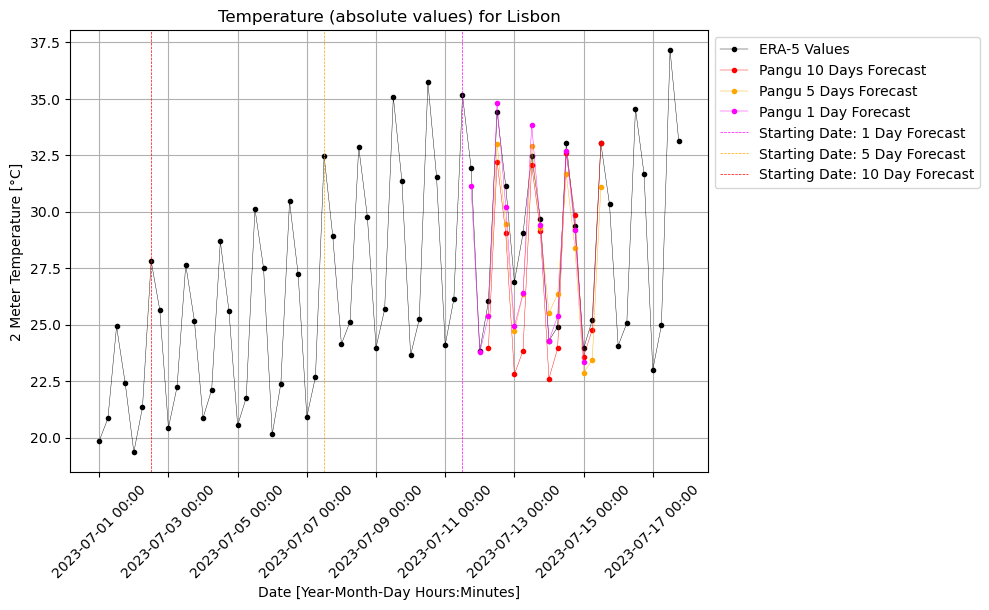

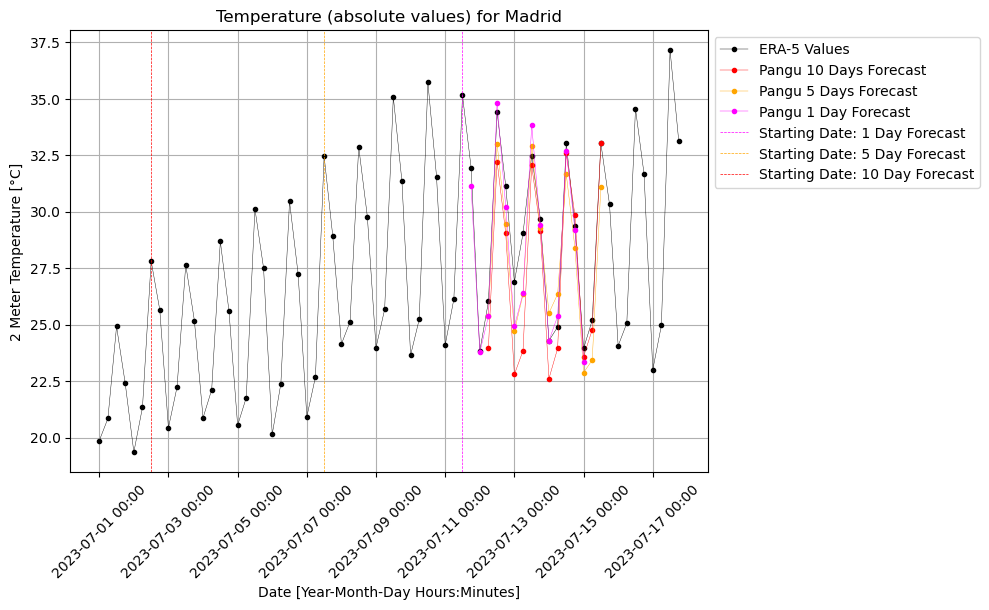

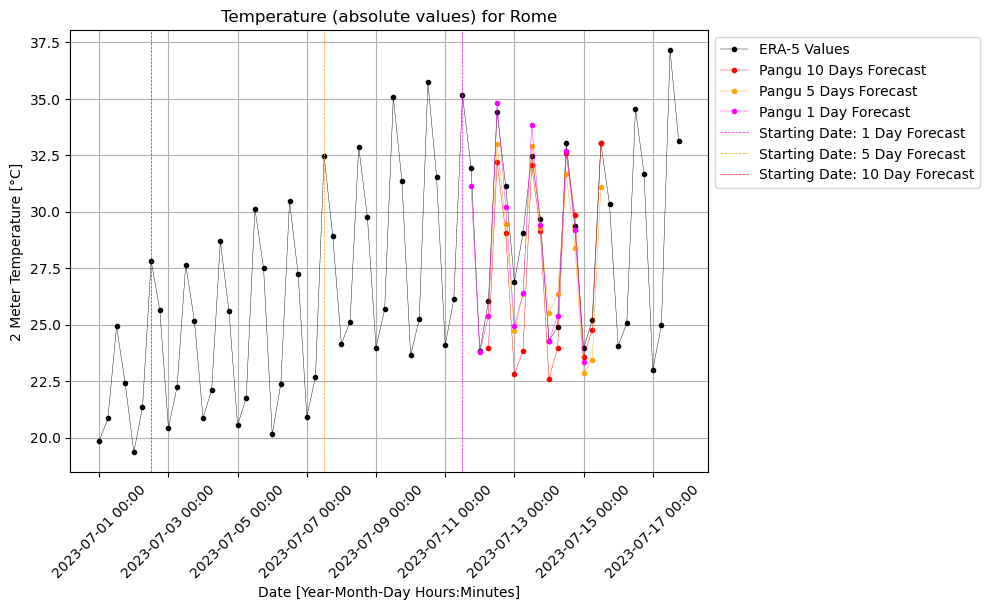

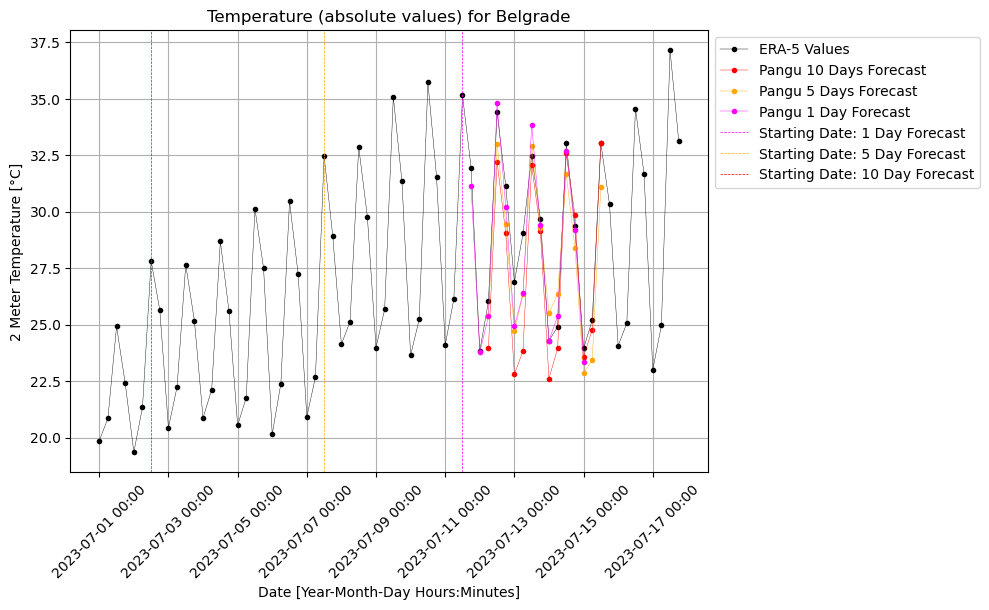

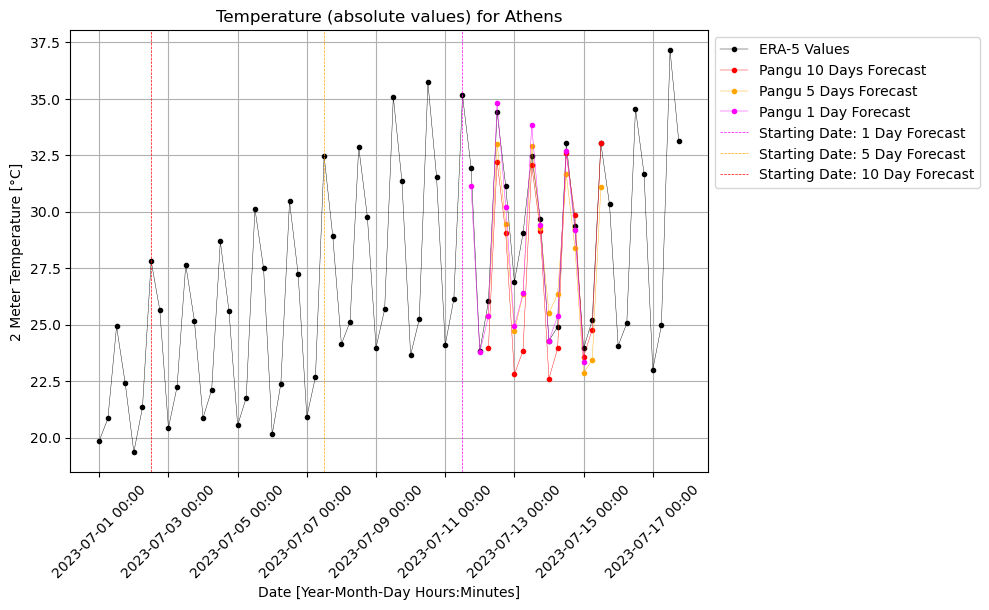

In [260]:
# Function call plot_temperature_absolute(lat, lon, location_name)
plot_temperature_absolute(38.736946, -9.142685, 'Lisbon')
plot_temperature_absolute(40.416775, -3.703790, 'Madrid')
plot_temperature_absolute(41.902782, 12.496366, 'Rome')
plot_temperature_absolute(44.787197, 20.457273, 'Belgrade')
plot_temperature_absolute(37.983810, 23.727539, 'Athens')

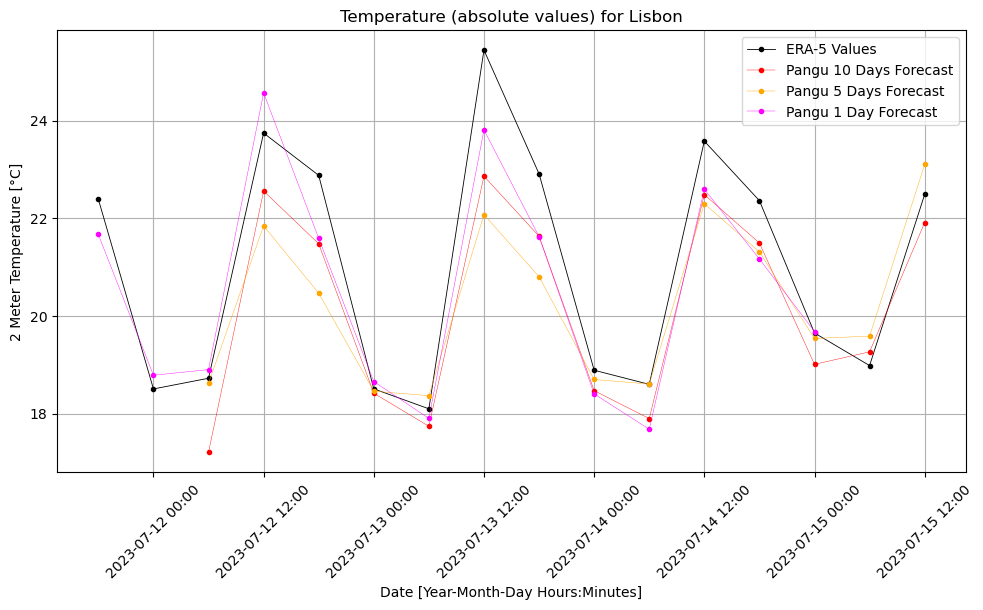

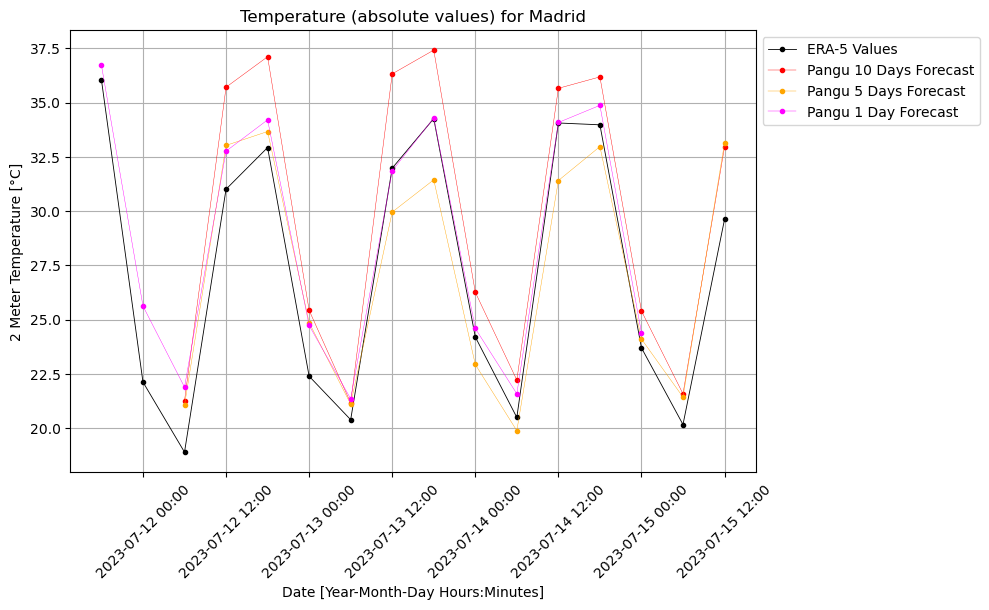

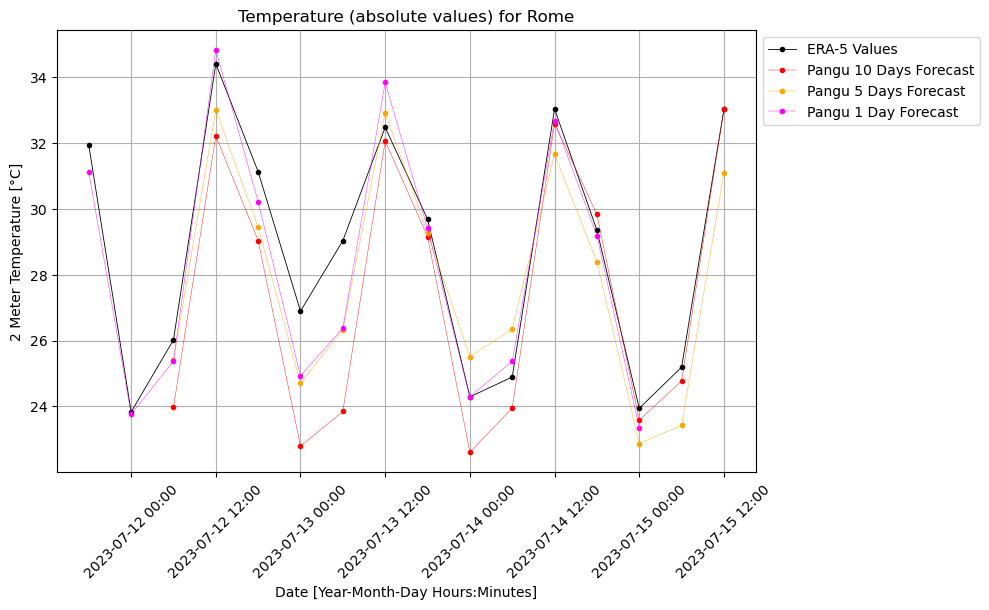

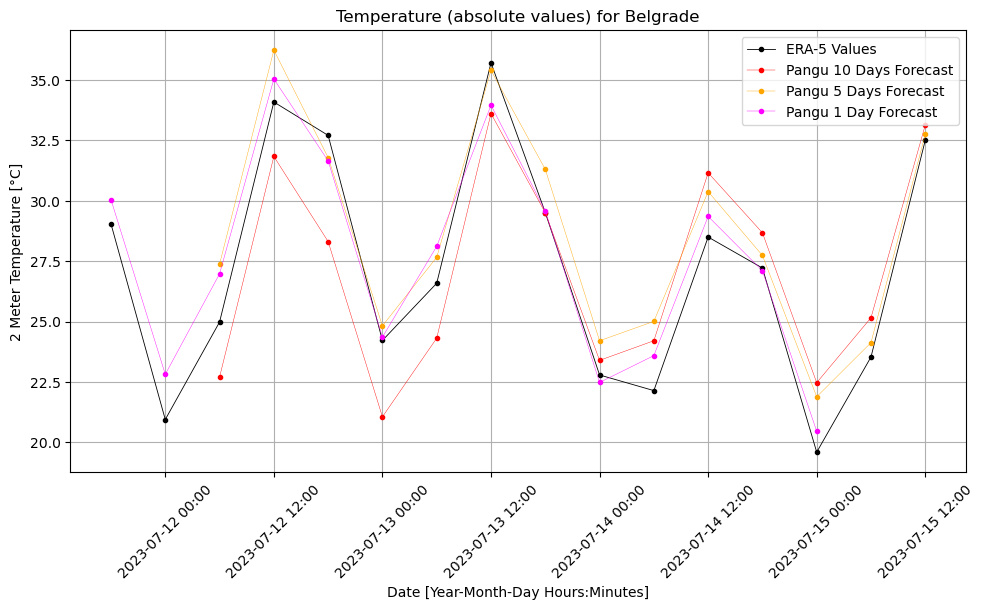

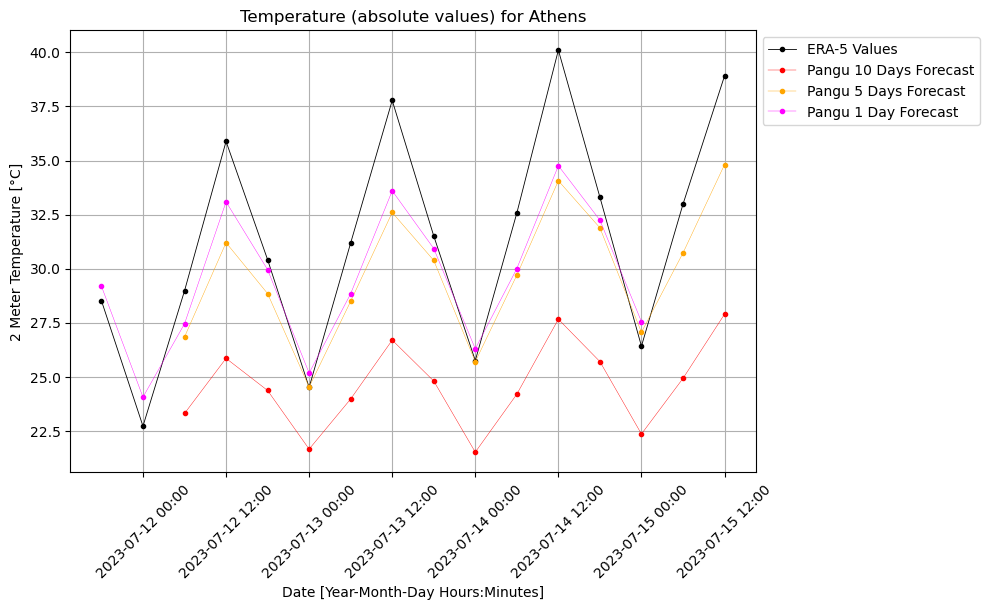

In [261]:
# Function call plot_zoomed_temperature_absolute(lat, lon, location_name)
plot_zoomed_temperature_absolute(38.736946, -9.142685, 'Lisbon')
plot_zoomed_temperature_absolute(40.416775, -3.703790, 'Madrid')
plot_zoomed_temperature_absolute(41.902782, 12.496366, 'Rome')
plot_zoomed_temperature_absolute(44.787197, 20.457273, 'Belgrade')
plot_zoomed_temperature_absolute(37.983810, 23.727539, 'Athens')

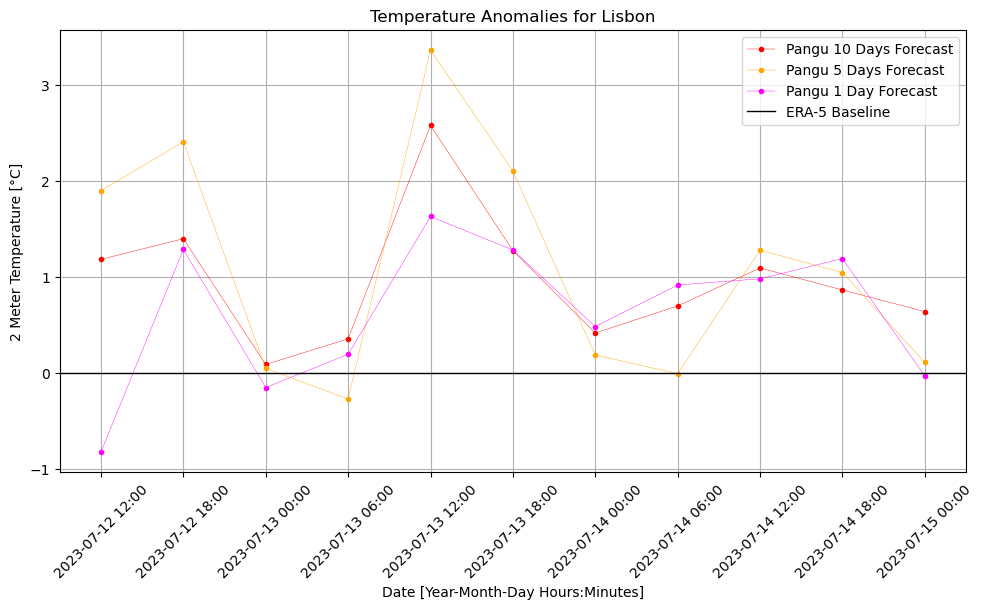

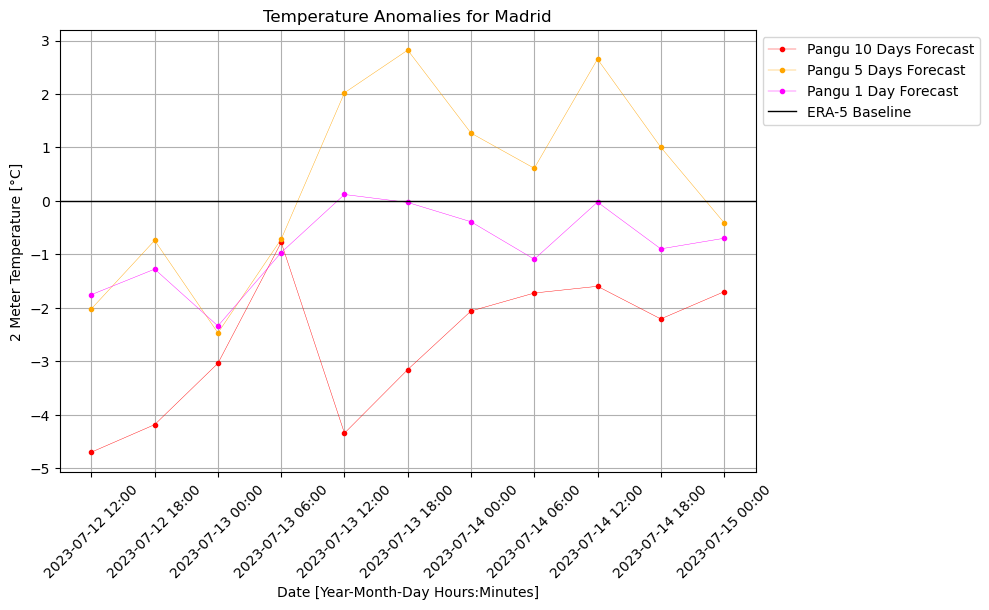

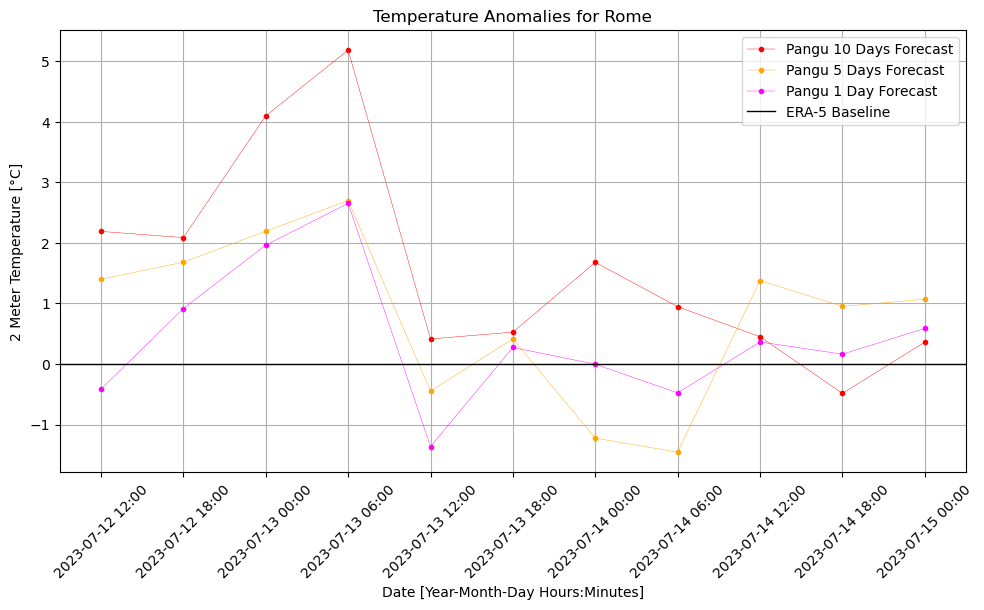

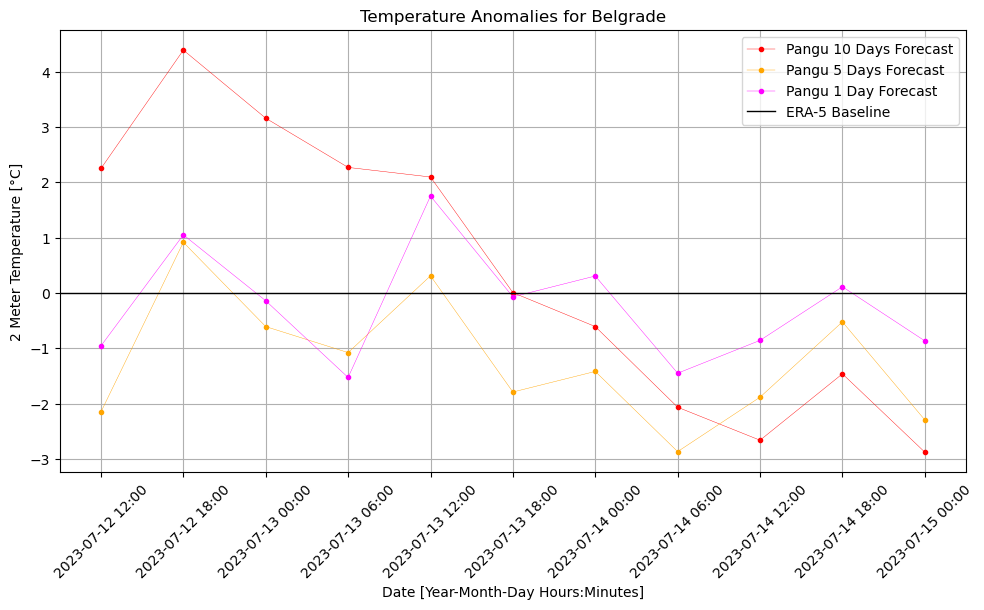

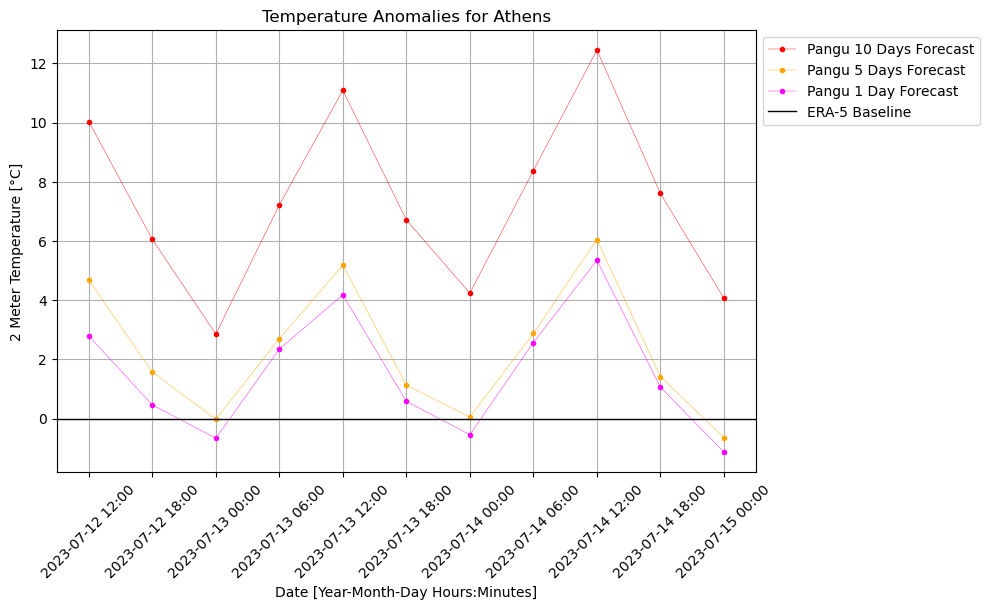

In [262]:
# Function call plot_temperature_anomalies(lat, lon, location_name)
Lisbon = plot_temperature_anomalies(38.736946, -9.142685, 'Lisbon')
Madrid = plot_temperature_anomalies(40.416775, -3.703790, 'Madrid')
Rome = plot_temperature_anomalies(41.902782, 12.496366, 'Rome')
Belgrade = plot_temperature_anomalies(44.787197, 20.457273, 'Belgrade')
Athens = plot_temperature_anomalies(37.983810, 23.727539, 'Athens')